In [ ]:
!pip install -q transformers einops accelerate langchain bitsandbytes

!pip install flash-attn

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
!pip install -U bitsandbytes

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, pipeline
from accelerate import Accelerator
import torch
import gc

# Define the model ID from available options.
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"  # Primary choice
# model_id = "microsoft/Phi-3-mini-128k-instruct"  # Alternative option
# model_id = "CohereForAI/c4ai-command-r-v01-4bit"  # Alternative option

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Define the quantization configuration to optimize model performance
quantization_config = BitsAndBytesConfig(
    activation_quantization_bits=16,
    weight_quantization_bits=16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Initialize the accelerator for optimized computation
accelerator = Accelerator()

# Determine the GPU architecture compatibility
if torch.cuda.is_available() and torch.cuda.get_device_capability(0) >= (8, 0):
    attn_implementation = "flash_attention_2"
else:
    attn_implementation = None
    print("Warning: FlashAttention requires an NVIDIA Ampere GPU or newer. Defaulting to standard attention.")

# Load the model with the specified configurations
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=quantization_config,
    attn_implementation=attn_implementation  # Use FlashAttention if supported
)

# Prepare the model using Accelerator for optimal device usage
model = accelerator.prepare(model)

# Confirm the model is ready and display the device being used
print(f"Model is ready and using {model.device}")

# Initialize the text generation pipeline with the prepared model
text_generation = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Unused kwargs: ['activation_quantization_bits', 'weight_quantization_bits']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Model is ready and using cuda:0


<ipython-input-12-528763b591c2>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  main_model.load_state_dict(torch.load('Main_Classifier_best_model.pth', map_location=device

Saving 436043_main.jpg to 436043_main.jpg


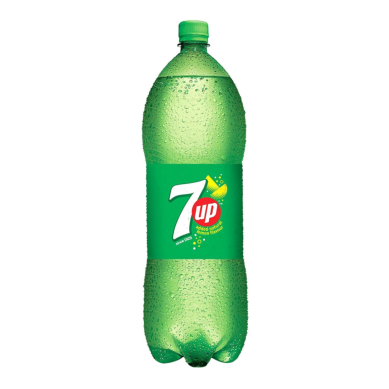

Main Predicted Class: Soda drinks
Confidence: 0.9979
Loading Soda Drinks Model...
Sub Predicted Class: Seven Up
Confidence: 1.0000


<ipython-input-12-528763b591c2>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Soda_drinks_best_model.pth', map_location=device))


In [ ]:
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the main classifier (Main_Classifier_best_model.pth)
main_model = models.resnet18(pretrained=False)
num_ftrs = main_model.fc.in_features
main_model.fc = nn.Linear(num_ftrs, 3)  # 3 classes: Soda drinks, Clothing, Mobile Phones
main_model.load_state_dict(torch.load('Main_Classifier_best_model.pth', map_location=device))
main_model = main_model.to(device)
main_model.eval()

# Define class names for the main classifier based on folder structure
main_class_names = ['Clothing', 'Mobile Phones', 'Soda drinks']

# Sub-classifier models
def load_soda_drinks_model():
    model = models.resnet18(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 3)  # 3 classes: Miranda, Pepsi, Seven Up
    model.load_state_dict(torch.load('Soda_drinks_best_model.pth', map_location=device))
    model = model.to(device)
    model.eval()
    return model

def load_clothing_model():
    model = models.resnet18(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: Pants, T-Shirt
    model.load_state_dict(torch.load('Clothes_best_model.pth', map_location=device))
    model = model.to(device)
    model.eval()
    return model

def load_mobile_phones_model():
    model = models.resnet18(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: Apple, Samsung
    model.load_state_dict(torch.load('Phone_best_model.pth', map_location=device))
    model = model.to(device)
    model.eval()
    return model

def convert_to_rgb(image):
    """
    Converts 'P' mode images with transparency to 'RGBA', and then to 'RGB'.
    This is to avoid transparency issues during model training.
    """
    if image.mode in ('P', 'RGBA'):
        return image.convert('RGB')
    return image

# Define preprocessing transformations (same used during training)
preprocess = transforms.Compose([
    transforms.Lambda(convert_to_rgb),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])

# Upload an image
uploaded = files.upload()

# Open the image using PIL
for file_name in uploaded.keys():
    image = Image.open(file_name)

# Display the uploaded image
plt.imshow(image)
plt.axis('off')
plt.show()

# Preprocess the image
input_image = preprocess(image).unsqueeze(0).to(device)

# Perform inference with the main classifier
with torch.no_grad():
    output = main_model(input_image)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    confidence, predicted_class = torch.max(probabilities, 0)

# Display the main classifier result
main_prediction = main_class_names[predicted_class]
print(f"Main Predicted Class: {main_prediction}")
print(f"Confidence: {confidence.item():.4f}")

# Load and apply the sub-classifier based on the main classification
if main_prediction == 'Soda drinks':
    print("Loading Soda Drinks Model...")
    soda_model = load_soda_drinks_model()
    sub_class_names = ['Miranda', 'Pepsi', 'Seven Up']
elif main_prediction == 'Clothing':
    print("Loading Clothing Model...")
    clothing_model = load_clothing_model()
    sub_class_names = ['Pants', 'T-Shirt']
elif main_prediction == 'Mobile Phones':
    print("Loading Mobile Phones Model...")
    phones_model = load_mobile_phones_model()
    sub_class_names = ['Apple', 'Samsung']

# Perform inference with the sub-classifier
with torch.no_grad():
    if main_prediction == 'Soda drinks':
        sub_output = soda_model(input_image)
    elif main_prediction == 'Clothing':
        sub_output = clothing_model(input_image)
    elif main_prediction == 'Mobile Phones':
        sub_output = phones_model(input_image)

    sub_probabilities = torch.nn.functional.softmax(sub_output[0], dim=0)
    sub_confidence, sub_predicted_class = torch.max(sub_probabilities, 0)

# Display the sub-classifier result
print(f"Sub Predicted Class: {sub_class_names[sub_predicted_class]}")
print(f"Confidence: {sub_confidence.item():.4f}")


In [ ]:

prompt = f"""
You are a Senior Sales Executive with over 10 years of experience in the industry. Your task is to create detailed product descriptions for each subclass based on your knowledge and the latest information from the internet.

The product descriptions should follow the structure provided below. For each product subclass, include the following sections: a brief overview, key features, available sizes or variations, and target audience. Please format the response as follows:

1. [Main Product]
   [Sub Product]
   [Brief description of the product that highlights its key attributes and what makes it stand out.]

   **Category:** [Main Product]
   **Flavors/Types/Models:** [Relevant details about the variety of the product]
   **Available Sizes/Options:** [List of available sizes, models, or options]
   **Key Features:** [List of notable features]
   **Audience:** [Target audience for the product]

Examples:

1. Soda Drinks
   Pepsi
   Pepsi is a world-famous carbonated soft drink known for its bold and refreshing cola taste. Its balance of sweetness and slight citrus hints makes it a favorite for those looking to quench their thirst. Pepsi pairs perfectly with meals, snacks, or on its own as a cool refreshment. Available in a variety of packaging, from cans to bottles, it caters to all kinds of preferences.

   **Category:** Soda Drink
   **Flavors:** Cola
   **Available Sizes:** 330ml, 500ml, 1.5L, 2L
   **Key Features:** Sweet cola taste, available in sugar-free and diet options.
   **Audience:** All age groups.

2. Clothing
   T-Shirts
   T-shirts are the ultimate casual wear staple, offering comfort and style for all occasions. They come in a variety of fabrics such as cotton, polyester, or a blend, and are available in numerous colors, patterns, and sizes. Whether plain or with printed designs, T-shirts are versatile and perfect for layering or wearing solo.

   **Category:** Clothing
   **Material:** Cotton, Polyester
   **Sizes Available:** S, M, L, XL, XXL
   **Key Features:** Lightweight, breathable, comfortable, machine-washable.
   **Audience:** Men, Women, Unisex.

3. Mobile Phones
   Samsung
   Samsung is a leading manufacturer of innovative smartphones that combine cutting-edge technology with sleek designs. Known for their high-quality cameras, long-lasting batteries, and vibrant displays, Samsung phones come with powerful processors, ample storage, and advanced features like water resistance and facial recognition. The Galaxy series is particularly popular, offering devices that cater to all budgets and needs.

   **Category:** Mobile Phones
   **Models:** Galaxy S Series, Galaxy Note Series, Galaxy A Series
   **Key Features:** High-resolution cameras, AMOLED display, fast charging, long battery life, 5G enabled.
   **Operating System:** Android
   **Audience:** Tech enthusiasts, professionals, general users.

4. Soda Drinks
   Seven Up
   Seven Up is a crisp and refreshing lemon-lime-flavored soft drink. It is caffeine-free, making it an ideal choice for those looking for a light, refreshing beverage without the buzz. Its citrusy flavor profile and effervescence offer a great option for mixing with juices or drinking chilled on a hot day.

   **Category:** Soda Drink
   **Flavors:** Lemon-Lime
   **Available Sizes:** 330ml, 500ml, 1.5L, 2L
   **Key Features:** Caffeine-free, natural lemon-lime flavor, thirst-quenching.
   **Audience:** All age groups.

Now, using the structure and examples provided, create similar descriptions for the following main product category: {main_prediction} and the specific sub product: {sub_class_names[sub_predicted_class]}, based on your expertise and the confidence scores:{main_prediction} : {sub_class_names[sub_predicted_class]}.


"""




# Generate the text using the prompt
generated_texts = text_generation(prompt, max_length=7000,max_new_tokens=2000, truncation=True, num_return_sequences=1)
for generated in generated_texts:
    print(generated['generated_text'])

# Clean up resources
torch.cuda.empty_cache()
gc.collect()


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Both `max_new_tokens` (=2000) and `max_length`(=7000) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



You are a Senior Sales Executive with over 10 years of experience in the industry. Your task is to create detailed product descriptions for each subclass based on your knowledge and the latest information from the internet. 

The product descriptions should follow the structure provided below. For each product subclass, include the following sections: a brief overview, key features, available sizes or variations, and target audience. Please format the response as follows:

1. [Main Product]
   [Sub Product]
   [Brief description of the product that highlights its key attributes and what makes it stand out.]

   **Category:** [Main Product]
   **Flavors/Types/Models:** [Relevant details about the variety of the product]
   **Available Sizes/Options:** [List of available sizes, models, or options]
   **Key Features:** [List of notable features]
   **Audience:** [Target audience for the product]

Examples:

1. Soda Drinks
   Pepsi
   Pepsi is a world-famous carbonated soft drink known fo

0

In [ ]:
# Generate the text using the prompt
generated_texts = text_generation(prompt, max_length=7000,max_new_tokens=2000, truncation=True, num_return_sequences=1)
for generated in generated_texts:
    print(generated['generated_text'])

# Clean up resources
torch.cuda.empty_cache()
gc.collect()


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Both `max_new_tokens` (=2000) and `max_length`(=7000) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



You are a Senior Sales Executive with over 10 years of experience in the industry. Your task is to create detailed product descriptions for each subclass based on your knowledge and the latest information from the internet. 

The product descriptions should follow the structure provided below. For each product subclass, include the following sections: a brief overview, key features, available sizes or variations, and target audience. Please format the response as follows:

1. [Main Product]
   [Sub Product]
   [Brief description of the product that highlights its key attributes and what makes it stand out.]

   **Category:** [Main Product]
   **Flavors/Types/Models:** [Relevant details about the variety of the product]
   **Available Sizes/Options:** [List of available sizes, models, or options]
   **Key Features:** [List of notable features]
   **Audience:** [Target audience for the product]

Examples:

1. Soda Drinks
   Pepsi
   Pepsi is a world-famous carbonated soft drink known fo

0